In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar datos
data_path = './train.csv'
mnist_data = pd.read_csv(data_path)
X = mnist_data.drop(labels=['label'], axis=1).values / 255.0
y = mnist_data['label'].values
X = X.reshape(-1, 1, 28, 28)

# Dividir datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

mnist_data_val = pd.read_csv('./test.csv')
X_test = mnist_data_val.values / 255.0
X_test = X_test.reshape(-1, 1, 28, 28)
X_test = torch.tensor(X_test, dtype=torch.float32)



# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Crear cargadores de datos
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [5]:
# Definir la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Crear el modelo
model = CNN()

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [6]:

# Entrenamiento
for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y_batch).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / len(y_val)
    print(f'Epoch {epoch}: Val Loss: {val_loss}, Val Accuracy: {val_acc}')


Epoch 0: Val Loss: 0.06730306790577191, Val Accuracy: 0.9777380952380952
Epoch 1: Val Loss: 0.06718214049540235, Val Accuracy: 0.979047619047619
Epoch 2: Val Loss: 0.04861150368533069, Val Accuracy: 0.9851190476190477
Epoch 3: Val Loss: 0.051121719722163325, Val Accuracy: 0.9840476190476191
Epoch 4: Val Loss: 0.03611408858286626, Val Accuracy: 0.9891666666666666
Epoch 5: Val Loss: 0.03837218894543846, Val Accuracy: 0.988452380952381
Epoch 6: Val Loss: 0.040540109676812514, Val Accuracy: 0.9872619047619048
Epoch 7: Val Loss: 0.029256352475909585, Val Accuracy: 0.9903571428571428
Epoch 8: Val Loss: 0.04703066801911601, Val Accuracy: 0.9877380952380952
Epoch 9: Val Loss: 0.0335771777365401, Val Accuracy: 0.9907142857142858


In [8]:
# Cargando los datos de prueba
test_data_path = './test.csv'
test_data = pd.read_csv(test_data_path)

# Mostrando las primeras filas para entender la estructura
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


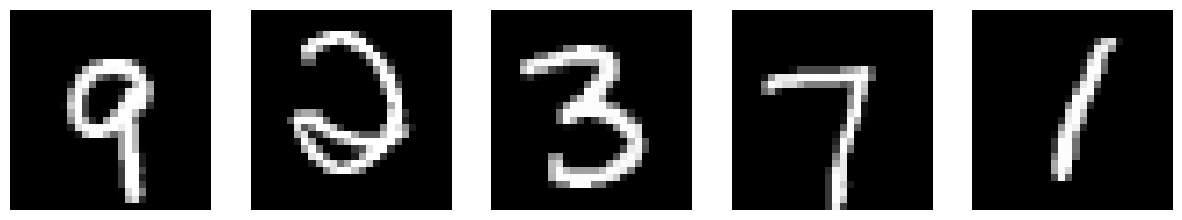

array([ 4189, 19927, 24131,  7203,  7146])

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Seleccionando 5 índices aleatorios
random_indices = np.random.choice(test_data.shape[0], 5, replace=False)

# Creando una figura para visualizar las imágenes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Visualizando las imágenes seleccionadas
for i, idx in enumerate(random_indices):
    image_pixels = test_data.iloc[idx].values.reshape(28, 28)
    axes[i].imshow(image_pixels, cmap='gray')
    axes[i].axis('off')

plt.show()

# Retornando los índices seleccionados para su uso posterior
random_indices


In [10]:
# Seleccionando las imágenes correspondientes a los índices aleatorios
selected_images = test_data.iloc[random_indices].values.reshape(-1, 1, 28, 28)

# Convirtiendo a tensores de PyTorch
selected_images_tensor = torch.tensor(selected_images, dtype=torch.float32)

# Prediciendo los dígitos usando el modelo
model.eval()
with torch.no_grad():
    predictions = model(selected_images_tensor)
    predicted_labels = torch.argmax(predictions, 1)

# Imprimiendo las predicciones
print("Predicciones:", predicted_labels.numpy())


Predicciones: [9 2 3 7 1]
